<a href="https://colab.research.google.com/github/rajarajeswarir/Hands-on-Machine-Learning/blob/main/Insurance_Cost_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Insurance cost prediction given the following details

**age**: age of primary beneficiary

**sex**: insurance contractor gender, female, male

**bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children**: Number of children covered by health insurance / Number of dependents

**smoker**: Smoking

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**charges**: Individual medical costs billed by health insurance

#Load the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link = 'https://drive.google.com/file/d/1-u7JkfU1g-KkapWnINPbLR3oQKsGr7Cm/view?usp=drive_link'

id = link.split("/")[-2]

# Initialize GoogleDriveFile instance with file id.
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('insurance.csv')  # Download file as 'insurance.csv'.
insurance_df = pd.read_csv('insurance.csv')


##Take a quick look at the Data Structure

In [4]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


##Analysing categorical data

In [6]:
insurance_df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


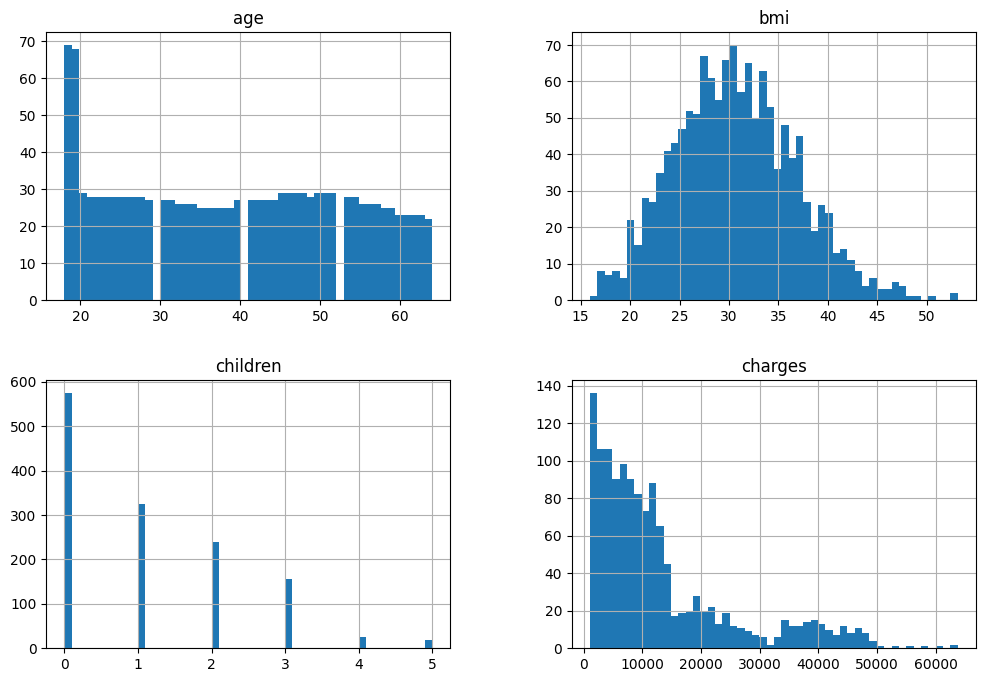

In [8]:
insurance_df.hist(bins=50, figsize=(12, 8))
plt.show()

##Create a Test Set

In [9]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
insurance_with_id = insurance_df.reset_index() #adds an 'index' column
train_set, test_set = split_data_with_id_hash(insurance_with_id, 0.2, "index")

##Looking for Correlations

In [11]:
corr_matrix = insurance_df.corr()

<ipython-input-11-9d256507b8e3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = insurance_df.corr()


In [12]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

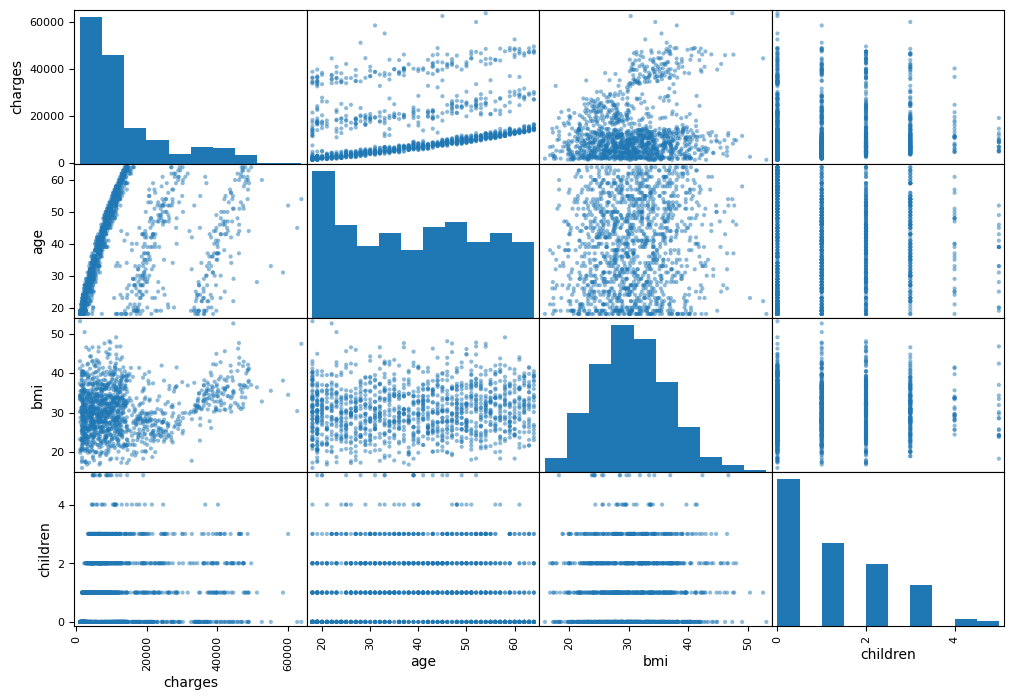

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi", "children"]
scatter_matrix(insurance_df[attributes], figsize=(12, 8))
plt.show()

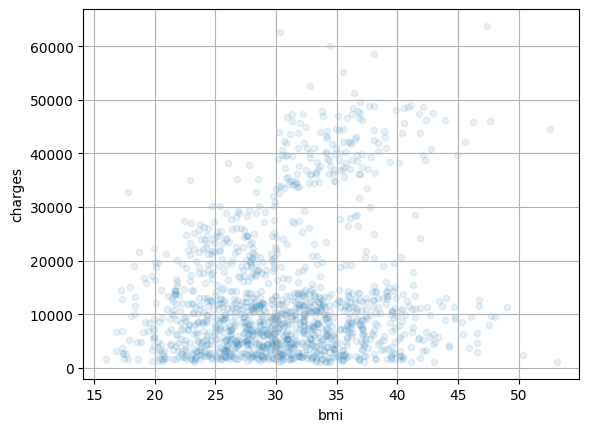

In [14]:
insurance_df.plot(kind="scatter", x="bmi", y="charges", alpha=0.1, grid=True)
plt.show()

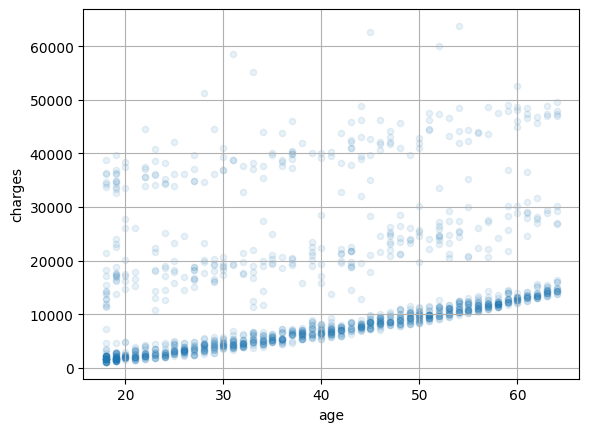

In [15]:
insurance_df.plot(kind="scatter", x="age", y="charges", alpha=0.1, grid=True)
plt.show()

##Handling Text and Categorical Attributes

In [16]:
insurance_cat_sex = insurance_df[["sex"]]
insurance_cat_sex.head(8)

,sex
0,female
1,male
2,male
3,male
4,male
5,female
6,female
7,female


In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer #  helper function which aids in the transformations of columns


transformer = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    remainder = 'passthrough')

transformed = transformer.fit_transform(insurance_df) #outputs numpy array with neither column names nor index
transformed_df = pd.DataFrame(transformed,
                              columns = transformer.get_feature_names_out()) #Wrapping in a DataFrame and recovered column names and index

print(transformed_df.head())

   onehotencoder__sex_female  onehotencoder__sex_male  \
0                        1.0                      0.0   
1                        0.0                      1.0   
2                        0.0                      1.0   
3                        0.0                      1.0   
4                        0.0                      1.0   

   onehotencoder__smoker_no  onehotencoder__smoker_yes  \
0                       0.0                        1.0   
1                       1.0                        0.0   
2                       1.0                        0.0   
3                       1.0                        0.0   
4                       1.0                        0.0   

   onehotencoder__region_northeast  onehotencoder__region_northwest  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                       

In [18]:
insurance_with_id = transformed_df.reset_index() #adds an 'index' column
train_set, test_set = split_data_with_id_hash(insurance_with_id, 0.2, "index")

In [19]:
train_set.head(8)

,index,onehotencoder__sex_female,onehotencoder__sex_male,onehotencoder__smoker_no,onehotencoder__smoker_yes,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,remainder__age,remainder__bmi,remainder__children,remainder__charges
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,19.0,27.900,0.0,16884.92400
1,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0,1725.55230
3,3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0,21984.47061
4,4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0,3866.85520
6,6,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,46.0,33.440,1.0,8240.58960
7,7,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,37.0,27.740,3.0,7281.50560
8,8,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,37.0,29.830,2.0,6406.41070
9,9,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,60.0,25.840,0.0,28923.13692


In [20]:
insurance = train_set.drop("remainder__charges", axis=1)
insurance_labels = train_set["remainder__charges"].copy()

##Select and Train a Model

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(insurance, insurance_labels)

LinearRegression()

In [22]:
insurance_predictions = lin_reg.predict(insurance)
insurance_predictions[:5]

array([24902.15454074,  3495.88819985,  3696.13894642,  5602.80368831,
       10333.00038607])

In [23]:
insurance_labels.iloc[:5].values

array([16884.924  ,  1725.5523 , 21984.47061,  3866.8552 ,  8240.5896 ])

In [24]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(insurance_labels, insurance_predictions,
                              squared=False)
lin_rmse

6002.917859680217

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(insurance, insurance_labels)

insurance_predictions = tree_reg.predict(insurance)
tree_rmse = mean_squared_error(insurance_labels, insurance_predictions,
                               squared=False)
tree_rmse #Overfitting of the data

0.0

##Better Evaluation Using Cross-Valiidation

In [26]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, insurance, insurance_labels,
                              scoring = "neg_root_mean_squared_error", cv=10)

pd.Series(tree_rmses).describe()

count       10.000000
mean      7163.417500
std       2059.870053
min       5435.033223
25%       6353.816655
50%       6480.268153
75%       7220.173157
max      12794.628911
dtype: float64

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

forest_rmses = -cross_val_score(forest_reg, insurance, insurance_labels,
                                scoring = "neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count      10.000000
mean     5034.854748
std      1393.818222
min      3295.099723
25%      4270.139734
50%      4643.289127
75%      5761.155643
max      8173.759003
dtype: float64

##Evaluate the system on the test set

In [28]:
X_test = test_set.drop("remainder__charges", axis=1)
y_test = test_set["remainder__charges"].copy()

final_pred = tree_reg.predict(X_test)
tree_rmse = mean_squared_error(y_test, final_pred,
                               squared=False)
tree_rmse #Overfitting of the data

6706.758502440005

In [29]:
from scipy import stats

confidence = 0.95
squared_errors = (final_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([5660.60318365, 7610.43959423])